In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)

import sys
from pyprojroot import here
sys.path.append("..") 

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Define helper functions

In [3]:
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset

def add_data(features: list[str], target: str, df: pd.DataFrame, add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
       #time = pm.Data("time", df["time_period"])
    if add_time:
        return X, Y, time
    else:
        return X,Y

In [58]:
# Function to create plot inputs
def generate_plot_inputs(target_variable: str, idata, disaster_type: str = "hydrological_disasters", df = pd.DataFrame ):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[target_variable, "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [59]:
#Plotting function
def plotting_function(idata, country: str, df: pd.DataFrame, target_variable: str):
    df_predictions = generate_plot_inputs(idata = idata, df = df, target_variable = target_variable)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data[target_variable], color='k', label='Actual Disaster Count')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("log_damage_adjusted_hydro")
    
    plt.show();
    

# Importing and cleaning data

In [7]:
rep_df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

In [8]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


# Plotting maps

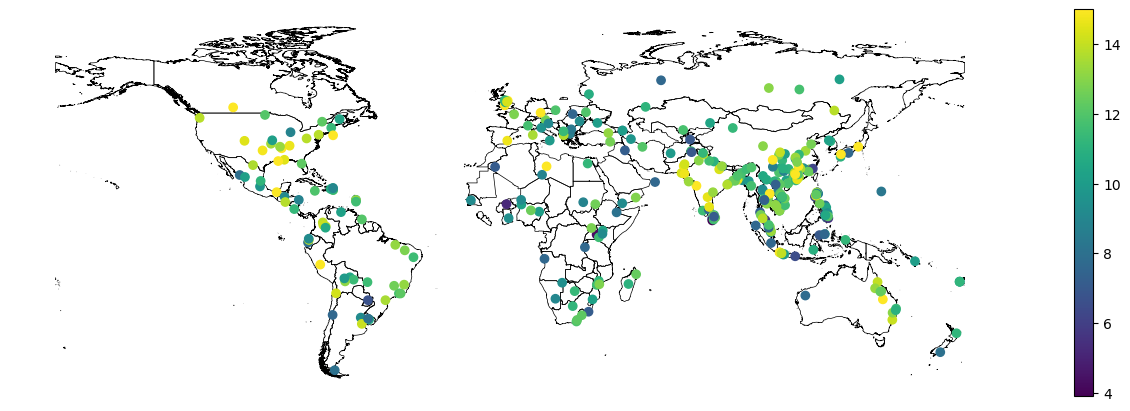

In [9]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
ax.axis('off')
plt.show()

In [10]:
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

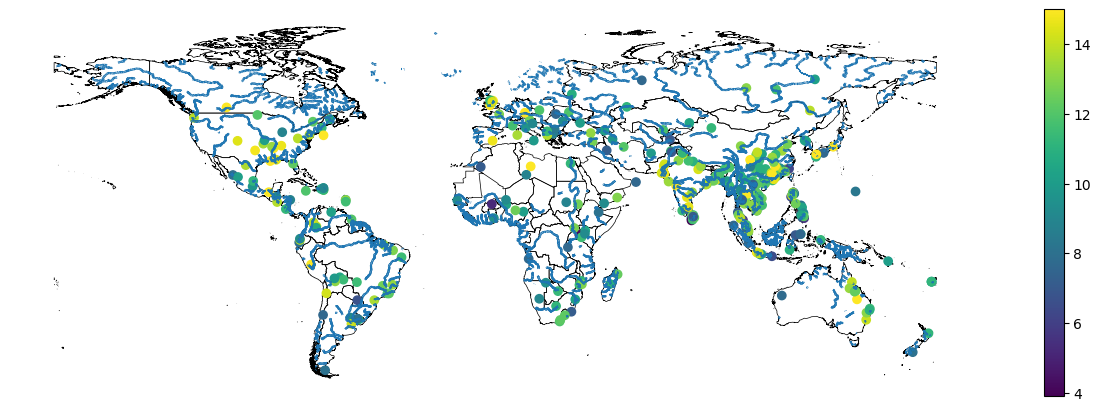

In [11]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.plot('log_damage_hydro', vmax=15, ax=ax, legend=True, aspect=1)
big_rivers.plot(ax=ax)
ax.axis('off')
plt.show()

In [12]:
lon_min, lat_min, lon_max, lat_max = laos.bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

In [13]:
laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [14]:
point_river_distance = get_distance_to_rivers(big_rivers, laos_points)

  0%|          | 0/2980 [00:00<?, ?it/s]

**Note:** Unfortunately there is only one event in LAO with data for Lat, Long and Total damages, and it is an earthquake

In [15]:
emdat["df_raw"].query('ISO == "LAO" ')[['Latitude', 'Longitude', "Total_Damage_Adjusted", 'Disaster Type']].dropna()

,Latitude,Longitude,Total_Damage_Adjusted,Disaster Type
25208,22.37,101.671,135.0,Earthquake


<Axes: >

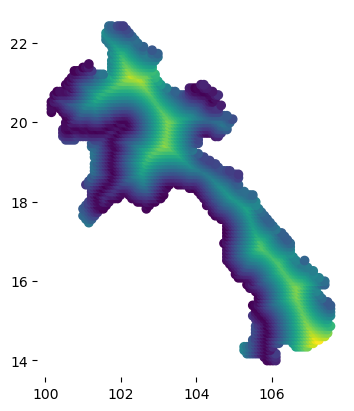

In [16]:
laos_points.join(point_river_distance).plot('closest_river')

# Simple damages model

**Note** Given that we do not have georeferenced hydrological disasters for LAO, once we calculate the "closest_river" variable, we will have NaN for LAO

In [17]:
#df for modeling

rep_df["log_damage_adjusted_hydro"] = np.log(rep_df["Total_Damage_Adjusted_hydro"].replace({0.0: np.nan}))

df_1 = rep_df[["ln_population_density", "population",  "ISO",
                  "year" , "log_damage_adjusted_hydro", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_1 = (df_1.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx, ISO =  pd.factorize(df_1["ISO"])
coords = {
    'ISO':ISO,
    'year':df_1["year"].unique(),
    'obs_idx':df_1.index,
    'feature': X_1.drop(columns = ["log_damage_adjusted_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_1.set_index(['ISO', 'year']).index, 'obs_idx')

In [18]:
#Simple Damages model
with pm.Model(coords=coords) as simple_damages_model1:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_adjusted_hydro", df = X_1 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [19]:
#Sampling
with simple_damages_model1:
    simple_damages_idata1 =sample_or_load(
            fp="simple_damages_model1",
            resample=False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    simple_damages_idata1 = simple_damages_idata1.assign_coords(xr_idx)

In [20]:
az.summary(simple_damages_idata1, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[ln_population_density],-2.342,0.728,-3.629,-0.911,0.088,0.065,71.0,61.0,1.10
beta[population],0.030,0.023,-0.013,0.074,0.001,0.001,606.0,1329.0,1.01
beta[ln_gdp_pc],-2.235,0.783,-3.689,-0.779,0.088,0.063,80.0,93.0,1.08
beta[square_ln_gdp_p],0.594,0.317,0.024,1.199,0.023,0.016,193.0,291.0,1.05
beta[precip_deviation],0.029,0.007,0.016,0.041,0.000,0.000,12902.0,5593.0,1.00
beta[co2],0.025,0.086,-0.132,0.193,0.007,0.005,133.0,326.0,1.05
sigma,2.104,0.048,2.015,2.196,0.000,0.000,10072.0,5973.0,1.00
sigma_log__,0.744,0.023,0.700,0.787,0.000,0.000,10072.0,5973.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


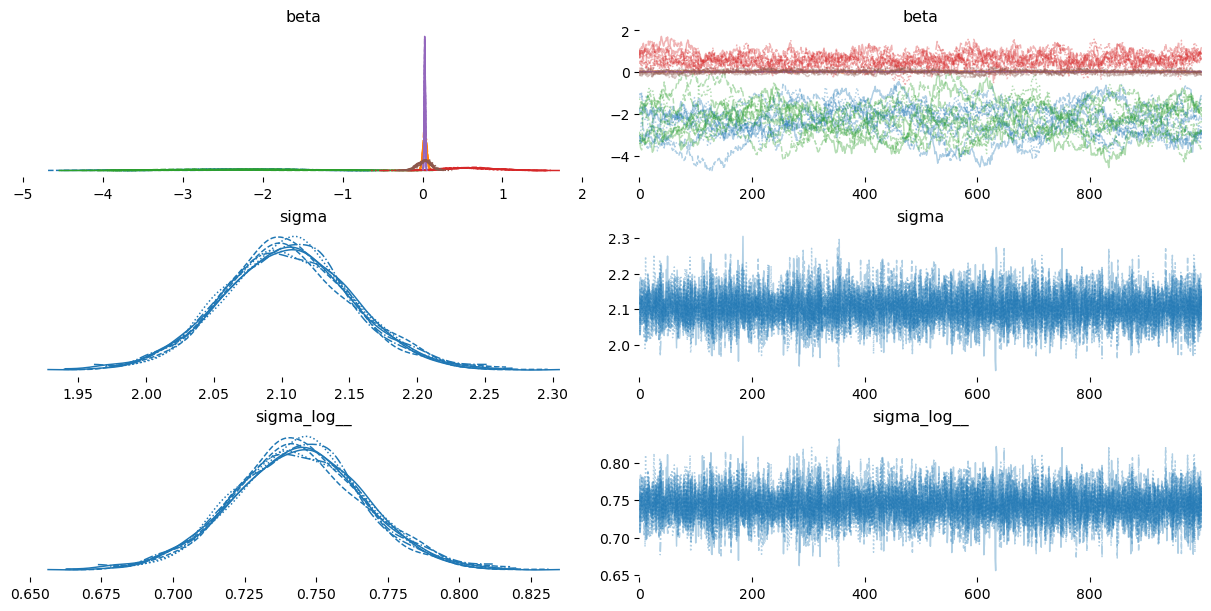

In [21]:
az.plot_trace(simple_damages_idata1, var_names =  ["~country_effect", "~country_effect_offset"]);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


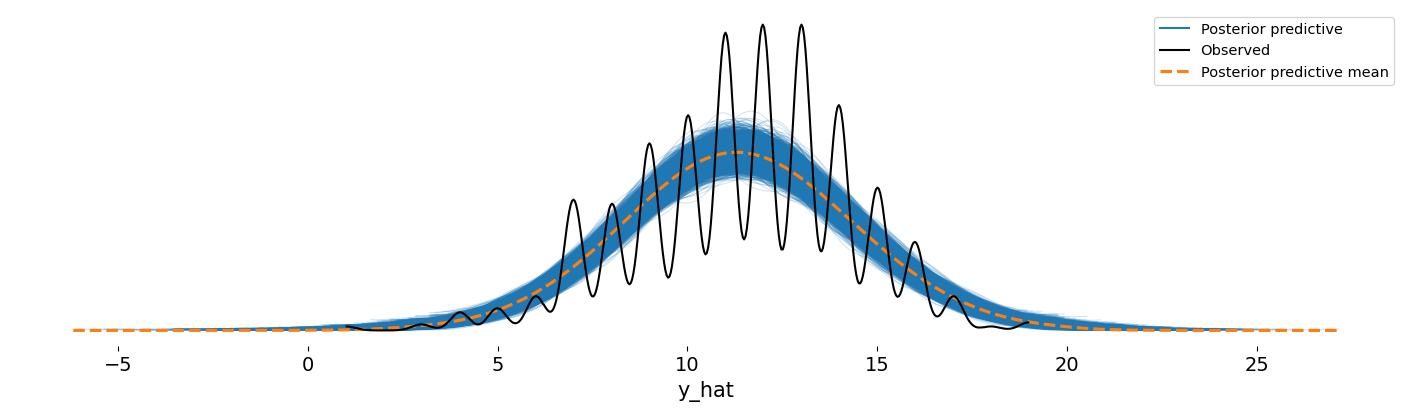

In [22]:
az.plot_ppc(simple_damages_idata1);

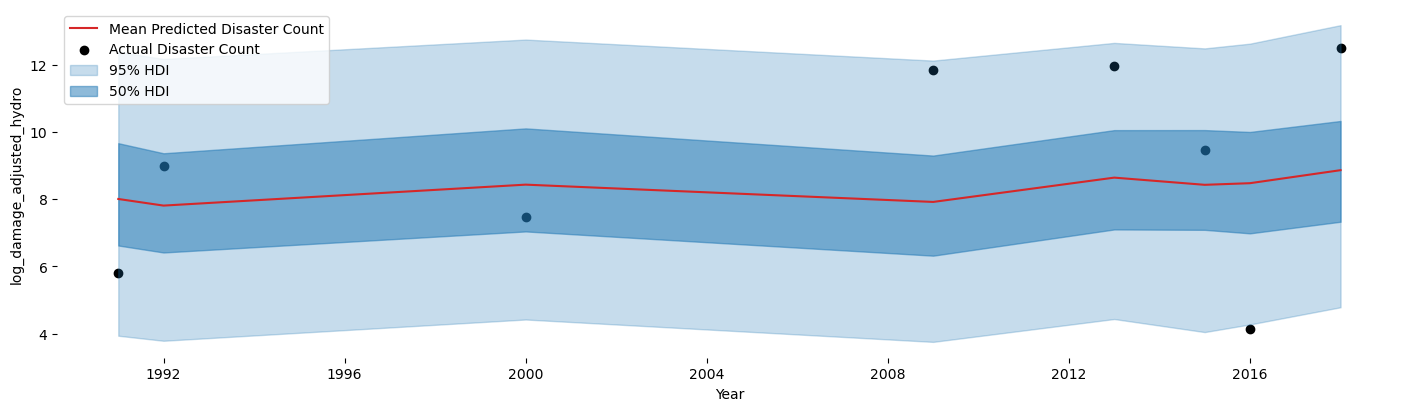

In [60]:
plotting_function(idata =simple_damages_idata1 , 
                  country = "LAO",
                  df = df_1 ,
                 target_variable= "log_damage_adjusted_hydro")

# Damages model with river distance

**Note** Given that we do not have georeferenced hydrological disasters for LAO, once we calculate the "closest_river" variable, we will have NaN for LAO

In [29]:
#df for modeling
merged_df = pd.merge(damage_df, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

df_2 = merged_df[[ "closest_river","ln_population_density", "population",  "ISO",
                  "year" , "log_damage_adjusted_hydro", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_2 = (df_2.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx_2, ISO_2 =  pd.factorize(df_2["ISO"])
coords = {
    'ISO':ISO_2,
    'year':df_2["year"].unique(),
    'obs_idx':df_2.index,
    'feature': X_2.drop(columns = ["log_damage_adjusted_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_2.set_index(['ISO', 'year']).index, 'obs_idx')

In [40]:
#damages_with_river_model
with pm.Model(coords=coords) as damages_with_river_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_adjusted_hydro", df = X_2 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx_2] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [50]:
#Sampling
with damages_with_river_model:
    damages_with_river_idata =sample_or_load(
            fp="damages_with_river_model2",
            resample=False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    damages_with_river_idata = damages_with_river_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.13,31
,2000,0,0.12,31
,2000,0,0.12,31
,2000,0,0.11,31
,2000,0,0.13,31
,2000,0,0.11,31
,2000,0,0.12,31
,2000,0,0.12,63


Sampling: [y_hat]


Output()

Output()

In [51]:
az.summary(damages_with_river_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[closest_river],-0.002,0.010,-0.020,0.016,0.000,0.000,8891.0,5462.0,1.00
beta[ln_population_density],-2.038,0.748,-3.449,-0.668,0.083,0.059,82.0,94.0,1.07
beta[population],0.024,0.079,-0.122,0.175,0.008,0.006,102.0,282.0,1.05
beta[ln_gdp_pc],-1.495,0.763,-2.874,-0.097,0.075,0.054,103.0,120.0,1.07
beta[square_ln_gdp_p],0.196,0.557,-0.832,1.201,0.041,0.029,185.0,478.0,1.02
beta[precip_deviation],0.027,0.010,0.008,0.045,0.000,0.000,6788.0,6280.0,1.00
beta[co2],0.441,0.251,-0.017,0.931,0.020,0.014,165.0,326.0,1.02
sigma,1.836,0.063,1.718,1.954,0.001,0.001,7063.0,6354.0,1.00
sigma_log__,0.607,0.034,0.544,0.672,0.000,0.000,7063.0,6354.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


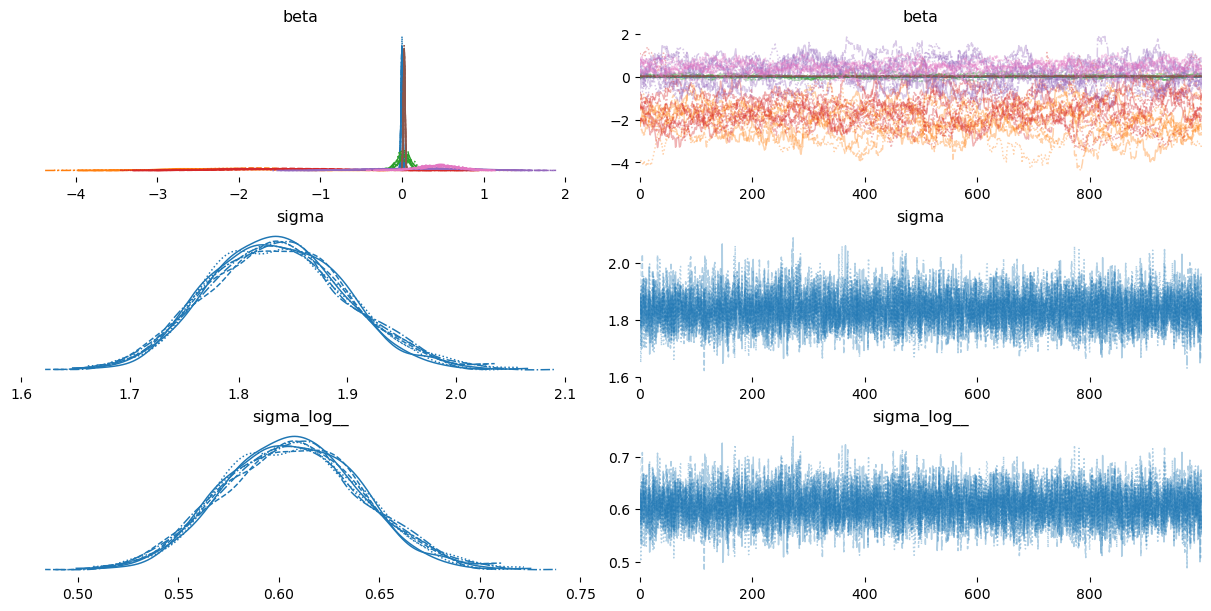

In [52]:
az.plot_trace(damages_with_river_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


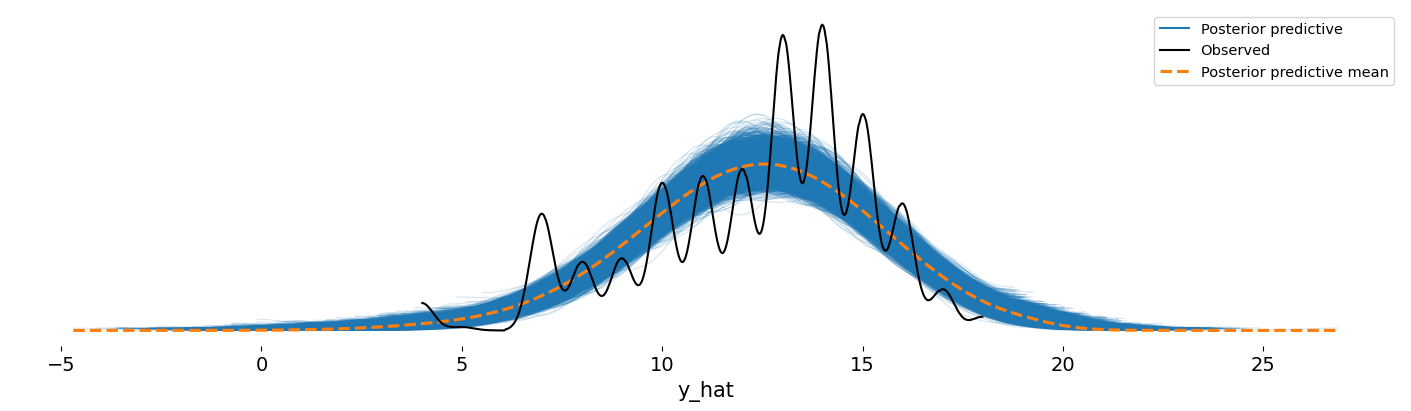

In [53]:
az.plot_ppc(damages_with_river_idata);

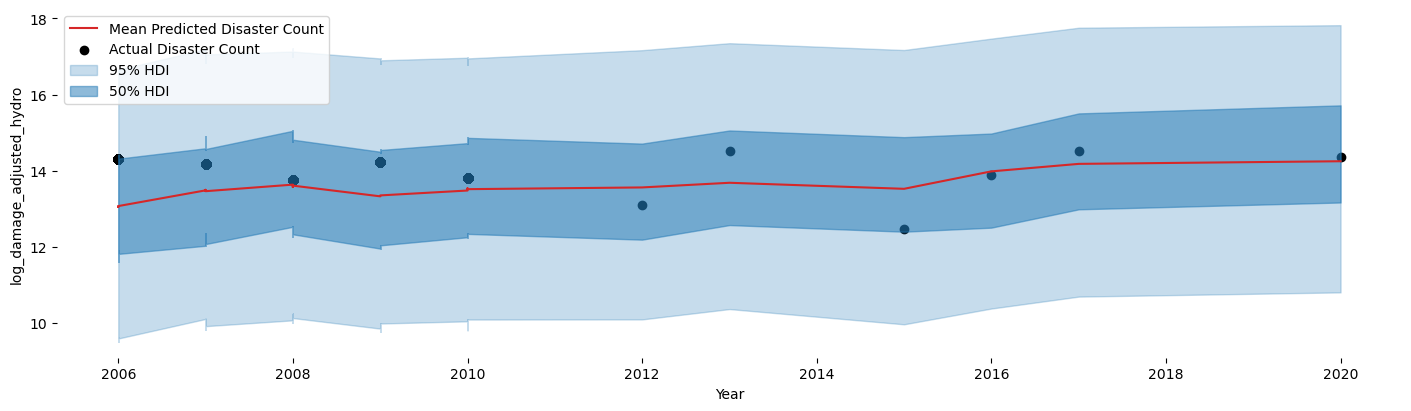

In [64]:
plotting_function(idata =damages_with_river_idata , 
                  country = "VNM",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

# Bonus: Event prediction with rivers

**Warning:** given that reduced number of events in LAO that have latitude and longitude information, by using the "closest_river" column for predictions, we will lose data points

In [66]:
#df for modeling
df_3 = merged_df[[ "closest_river","ln_population_density", "population",  "ISO",
                  "year" , "hydrological_disasters", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_3 = (df_3.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_idx_3, ISO_3 =  pd.factorize(df_3["ISO"])
coords = {
    'ISO':ISO_3,
    'year':df_3["year"].unique(),
    'obs_idx':df_3.index,
    'feature': X_3.drop(columns = ["hydrological_disasters"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_3.set_index(['ISO', 'year']).index, 'obs_idx')

In [70]:
#damages_with_river_model
with pm.Model(coords=coords) as hydrological_disasters_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "hydrological_disasters", df = X_3 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_idx_3] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    psi = pm.Beta('psi', alpha=2, beta=5)
    alpha = pm.Exponential("alpha",1)
    y_hat = pm.ZeroInflatedNegativeBinomial("y_hat", mu=mu, psi = psi, alpha = alpha , observed= Y , dims = ["obs_idx"])

In [75]:
#Sampling
with hydrological_disasters_model:
    hydrological_disasters_idata =sample_or_load(
            fp="hydrological_disasters_model2",
            resample=True,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "draws": 1000,
            })

    hydrological_disasters_idata = hydrological_disasters_idata.assign_coords(xr_idx)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.15,31
,2000,0,0.15,31
,2000,0,0.16,31
,2000,0,0.16,31
,2000,0,0.16,31
,2000,0,0.16,31
,2000,0,0.15,31
,2000,0,0.16,31


Sampling: [y_hat]


Output()

Output()

In [76]:
az.summary(hydrological_disasters_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,22.770,3.125,17.298,28.805,0.023,0.018,19127.0,5927.0,1.00
alpha_log__,3.116,0.137,2.855,3.363,0.001,0.001,19127.0,5927.0,1.00
beta[closest_river],-0.048,0.022,-0.092,-0.010,0.000,0.000,16975.0,6365.0,1.00
beta[ln_population_density],-0.748,0.878,-2.469,0.824,0.044,0.031,405.0,856.0,1.02
beta[population],0.213,0.120,-0.023,0.424,0.008,0.005,248.0,525.0,1.02
beta[ln_gdp_pc],-0.665,0.869,-2.211,1.087,0.044,0.031,389.0,769.0,1.01
beta[square_ln_gdp_p],-1.157,0.715,-2.510,0.143,0.026,0.018,776.0,1360.0,1.01
beta[precip_deviation],0.140,0.021,0.101,0.181,0.000,0.000,14393.0,6444.0,1.00
beta[co2],-0.301,0.420,-1.096,0.469,0.022,0.016,359.0,841.0,1.01
psi,0.994,0.003,0.989,0.998,0.000,0.000,17438.0,5281.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


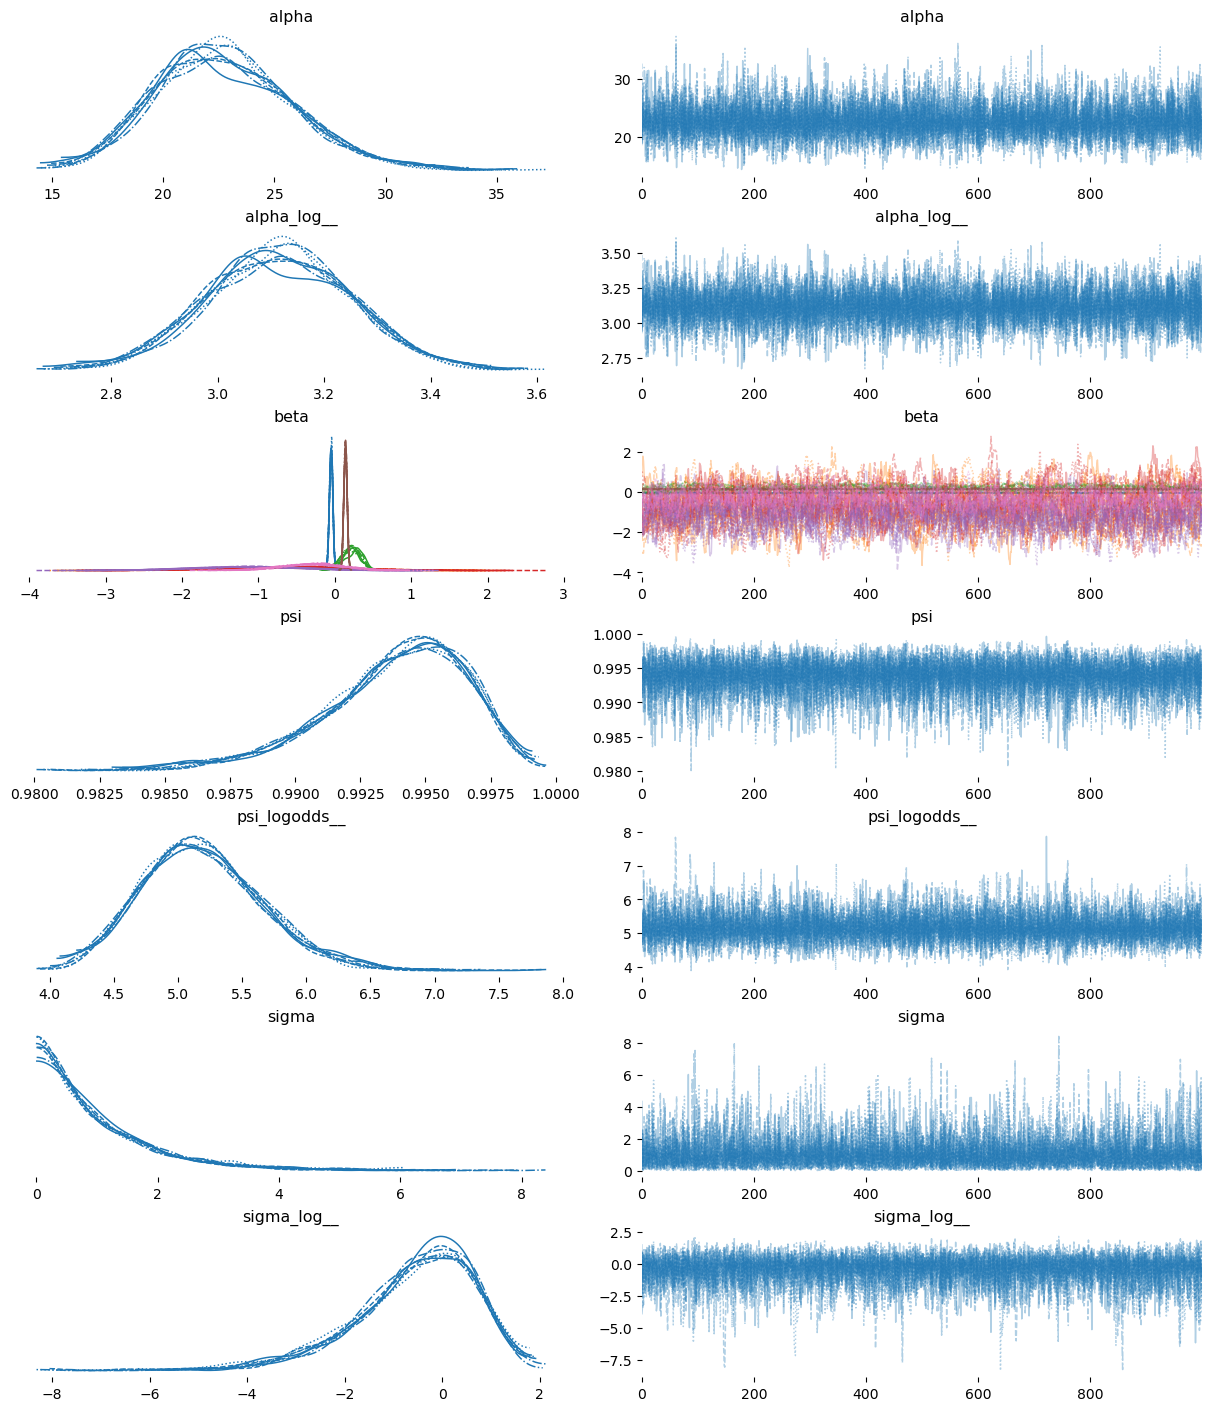

In [78]:
az.plot_trace(hydrological_disasters_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

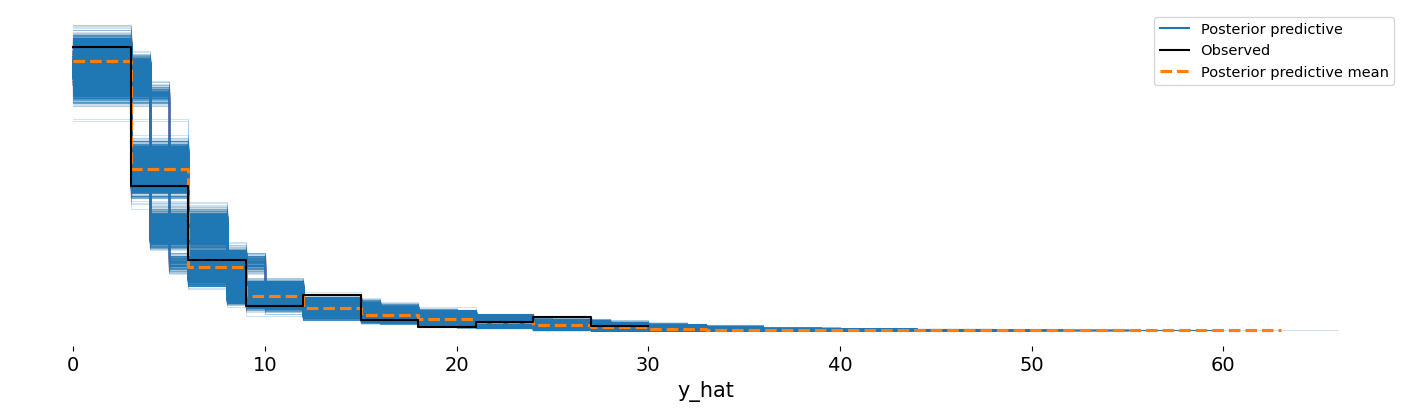

In [79]:
az.plot_ppc(hydrological_disasters_idata);

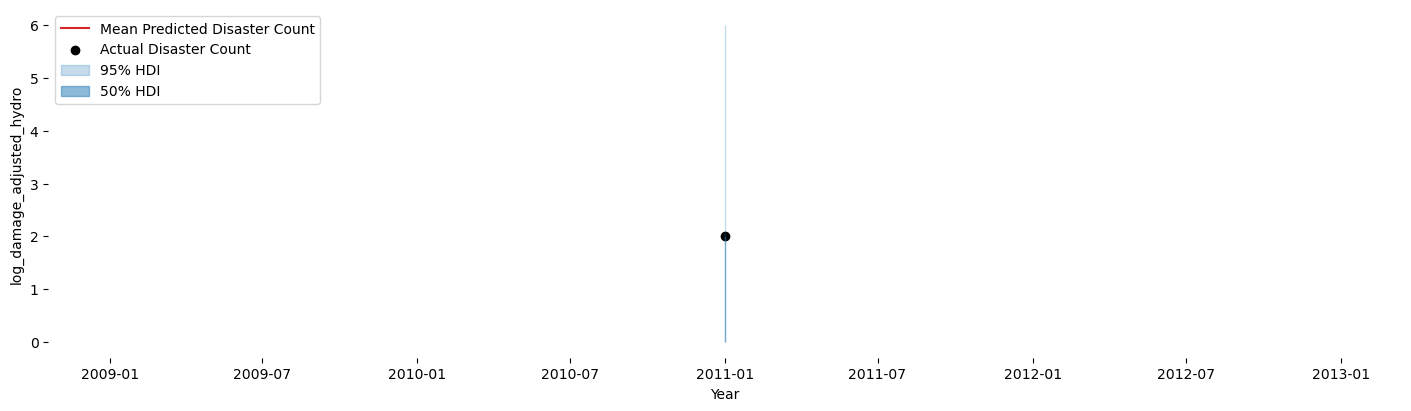

In [100]:
plotting_function(idata =hydrological_disasters_idata , 
                  country = "LAO",
                  df = df_3,
                 target_variable= "hydrological_disasters")

In [103]:
emdat["df_inten_filtered_adjusted"].shape

(12936, 9)

In [105]:
emdat2 = emdat["df_inten_filtered_adjusted"]

In [104]:
emdat2["Total_Damage_Adjusted"]

ISO  Start_Year
AFG  1969-01-01    0.0
     1970-01-01    0.0
     1971-01-01    0.0
     1972-01-01    0.0
     1973-01-01    0.0
                  ... 
ZWE  2020-01-01    0.0
     2021-01-01    0.0
     2022-01-01    0.0
     2023-01-01    0.0
     2024-01-01    0.0
Name: Total_Damage_Adjusted, Length: 12936, dtype: float64

In [107]:
emdat2[~emdat2['Total_Damage_Adjusted'].replace({0.0: np.nan}).isna()]

Deaths  Homeless  Injured  Numb_Affected  Total_Affected  \
ISO Start_Year                                                             
AFG 1978-01-01   120.0    7500.0    140.0       264044.0        271684.0   
    1988-01-01     0.0       0.0      0.0       161000.0        161000.0   
    1991-01-01  1143.0    9400.0      0.0       130000.0        139400.0   
    1992-01-01   450.0       0.0      0.0         4000.0          4000.0   
    2000-01-01    37.0       0.0      0.0      2580000.0       2580000.0   
...                ...       ...      ...            ...             ...   
ZWE 2001-01-01    13.0       0.0      0.0      6030000.0       6030000.0   
    2003-01-01     2.0       0.0      0.0        18000.0         18000.0   
    2013-01-01   125.0       0.0      0.0      4309700.0       4309700.0   
    2014-01-01    14.0       0.0      2.0         2500.0          2502.0   
    2017-01-01   251.0   12895.0    128.0      7000000.0       7013023.0   

                Total_Damage  Total_Damage_Adjusted  Region  \
ISO Start_Year                                                
AFG 1978-01-01       52000.0               242889.0    Asia   
    1988-01-01      260000.0               669910.0    Asia   
    1991-01-01       60000.0               134238.0    Asia   
    1992-01-01        4000.0                 8686.0    Asia   
    2000-01-01          50.0                   88.0    Asia   
...                      ...                    ...     ...   
ZWE 2001-01-01        3600.0                 6195.0  Africa   
    2003-01-01      200000.0               331273.0  Africa   
    2013-01-01      500000.0               653987.0  Africa   
    2014-01-01       20000.0                25742.0  Africa   
    2017-01-01      189000.0               234941.0  Africa   

                         Subregion  
ISO Start_Year                      
AFG 1978-01-01       Southern Asia  
    1988-01-01       Southern Asia  
    1991-01-01       Southern Asia  
    1992-01-01       Southern Asia  
    2000-01-01       Southern Asia  
...                            ...  
ZWE 2001-01-01  Sub-Saharan Africa  
    2003-01-01  Sub-Saharan Africa  
    2013-01-01  Sub-Saharan Africa  
    2014-01-01  Sub-Saharan Africa  
    2017-01-01  Sub-Saharan Africa  

[1479 rows x 9 columns]

In [108]:
1479/ 12936

0.11433209647495361